In [1]:
from google.colab import files
uploaded = files.upload()

Saving Dataset030921.csv to Dataset030921.csv
Saving fitur5p10iknn-pso(1).txt to fitur5p10iknn-pso(1).txt
Saving slang.csv to slang.csv


# Sett Awal

In [2]:
!pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 2.9 MB/s 


In [3]:
!pip install pyswarms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104 kB 5.6 MB/s 


In [4]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import pyswarms as ps
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
from time import time
from random import random
from random import uniform
from tabulate import tabulate
from numpy.random import rand
from numpy.random import randint
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
class Particle:
    def __init__(self, x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i<self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i.copy()
            self.err_best_i=self.err_i
                    
    # update new particle velocity
    def update_velocity(self,pos_best_g):
        # w=0.9       # constant inertia weight (how much to weigh the previous velocity)
        # c1=0.5        # cognative constant
        # c2=0.3        # social constant
        
        for i in range(0,num_dimensions):
            r1=random()
            r2=random()
            
            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]
            
            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i]<bounds[i][0]:
                self.position_i[i]=bounds[i][0]
        
        
def minimize(costFunc, x0, bounds, num_particles, maxiter, verbose=False):
    global num_dimensions
    global w, c1, c2

    w=0.9
    c1=0.5
    c2=0.5
    num_dimensions=len(x0)
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group

    # establish the swarm
    swarm=[]
    for i in range(0,num_particles):
        swarm.append(Particle(x0))

    # begin optimization loop
    i=0
    while i<maxiter:
        x = np.array(pos_best_g)
        sel = x>0.5
        tot = sel.sum()
        pos_best_g = list(x)
        if verbose: print(f'iter: {i:>4d}, sel : {tot:6} best solution: {err_best_g:10.6f} , posisition: {pos_best_g}')
            
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i<err_best_g or err_best_g==-1:
                pos_best_g=list(swarm[j].position_i)
                err_best_g=float(swarm[j].err_i)
        
        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        i+=1

    # print final results
    if verbose:
        print('\nFINAL SOLUTION:')
        print(f'   > {i:>4d}')
        print(f'   > {pos_best_g}')
        print(f'   > {err_best_g}\n')

    return err_best_g, pos_best_g

def print_df(dframe):
    print(tabulate(dframe, headers='keys', tablefmt='psql', showindex=True))

# tournament selection
def selection(pop, scores, k=3):
  # first random selection
  selection_ix = randint(len(pop))
  for ix in randint(0, len(pop), k-1):
    # check if better (e.g. perform a tournament)
    if scores[ix] < scores[selection_ix]:
      selection_ix = ix
  return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]
 
# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() < r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]
 
# genetic algorithm
def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
  # initial population of random bitstring
  pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
  # keep track of best solution
  best, best_eval = 0, objective(pop[0])
  # enumerate generations
  for gen in range(n_iter):
    # evaluate all candidates in the population
    scores = [objective(c) for c in pop]
    # check for new best solution
    for i in range(n_pop):
      if scores[i] < best_eval:
        best, best_eval = pop[i], scores[i]
        print(">%d, new best %.3f = f(%s)" % (gen, scores[i] , pop[i]))
    # select parents
    selected = [selection(pop, scores) for _ in range(n_pop)]
    # create the next generation
    children = list()
    for i in range(0, n_pop, 2):
      # get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
      # crossover and mutation
      for c in crossover(p1, p2, r_cross):
        # mutation
        mutation(c, r_mut)
        # store for next generation
        children.append(c)
    # replace population
    pop = children
  return [best, best_eval]

def fitfuncGA(x):
  fitn = 0
  sel = np.array(x)==1
  tot = sum(sel)
  posisi.append(sel)
  total.append(tot)
  accuracy = cross_val_score(model, text_tw[:,sel], label_tw, scoring='accuracy', cv=10, n_jobs=-1).mean()
  acc.append(accuracy)
  fitn = alpha * (1-accuracy) + (1 - alpha) * (tot / feature_count)
  fitness.append(fitn)
  return fitn

In [6]:
df = pd.read_csv('Dataset030921.csv',sep=";", encoding='cp1252')
df

,date,tweet,retweet_count,favorite_count,username,follower,label
0,25/10/2021 06:59,Sehingga mahasiswa mendesak agar segera disahk...,0.0,2.0,EM_UBOfficial,68099.0,0
1,26/10/2021 05:59,Permendikbud tentang pencegahan KS dikit lg yuk,0.0,0.0,putriripuke,928.0,0
2,26/10/2021 06:09,Hari ini ada kabar gembira Permendikbud Penceg...,0.0,1.0,sugar2yourtea,39.0,0
3,26/10/2021 06:37,Alhamdulillah Permendikbud Pencegahan dan Pena...,1920.0,4328.0,Nisanurulhs,2230.0,0
4,26/10/2021 06:55,Gerak setiap orang yang berkomitmen memperjuan...,14.0,13.0,Gerpuan_unj,161.0,0
...,...,...,...,...,...,...,...
15632,30/12/2021 06:49,Apresiasi besar gue sampaikan untuk Kemendikbu...,0.0,1.0,skidipawpaw_,1270.0,0
15633,30/12/2021 06:57,Sama kaya narasi yg kemarin rame nolak Permend...,0.0,82.0,AinunAlJapari,177.0,0
15634,30/12/2021 07:08,Melegalkan zina ka klo kata org yg nolak itu 1...,0.0,0.0,leegokey,19.0,2
15635,30/12/2021 08:39,Dan di tahun 2021 RUU udah masuk tahap prolegn...,0.0,29.0,fatihyahdyalam,227.0,0


In [7]:
kamus_normalisasi = pd.read_csv("slang.csv",sep=";", encoding='cp1252')
normalisasi_dict = {}

for index, row in kamus_normalisasi.iterrows():
  if row[0] not in normalisasi_dict:
    normalisasi_dict[row[0]] = row[1]

stop_factory = StopWordRemoverFactory()
stopwordNLTK = stopwords.words('indonesian')
stopwordSastrawi = stop_factory.get_stop_words()
more_stopword = ['twitwar', 'repost', 'rt', 'are', 'deh','kah', 
                 'htg', 'wk','aa','cc','sih', 'ayo', 'si','dsb',
                 'loh','an','ma','dimana','eh','aduh','lho','oh',
                 'ii','yah','sok','ah','of','ei','er','ie','prof',
                 'gus','om','fess','do']
filterStopword = set(stopwordSastrawi + stopwordNLTK + more_stopword)

In [8]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

tweetStem = []
tweetJoin = []

for indeks,tweets in enumerate(df['tweet']):
  removed = []
  tweet = []
  # case folding
  tweets = tweets.lower()
  # cleaning
  tweets = ' '.join(re.sub('2021|21'," duaribuduasatu",tweets).split())
  tweets = ' '.join(re.sub('2022'," duaribuduadua",tweets).split())
  tweets = ' '.join(re.sub('30'," tigapuluh",tweets).split())
  tweets = ' '.join(re.sub('4|a{3,}',"a",tweets).split())
  parnwk = ("wk{2,}|wkw{2,}|y{2,}|ww+|kwk+|\d{5,}|haha+|z{2,}|xix+|xixi+|ixi+|xx+|wq+|hehe+|waka(ka)+")
  tweets = ' '.join(re.sub(parnwk," ",tweets).split())
  tweets = ' '.join(re.sub('3|ee+',"e",tweets).split())
  tweets = ' '.join(re.sub('h+',"h",tweets).split())
  tweets = ' '.join(re.sub('1|i{3,}',"i",tweets).split())
  tweets = ' '.join(re.sub('u{3,}',"u",tweets).split())
  tweets = ' '.join(re.sub('k+',"k",tweets).split())
  tweets = ' '.join(re.sub('s+',"s",tweets).split())
  tweets = ' '.join(re.sub('o+',"o",tweets).split())
  tweets = ' '.join(re.sub('r+',"r",tweets).split())
  tweets = ' '.join(re.sub('g{3,}',"g",tweets).split())
  tweets = ' '.join(re.sub("([^a-zA-Z])"," ",tweets).split())
  # normalisasi
  tweets = " ".join(normalisasi_dict.get(word, word) for word in tweets.split(' '))
  # stopword
  for t in tweets.split(' '):
    if t not in filterStopword:
      removed.append(t)
  for tweets in removed:
    tweet.append(tweets)
  tweets = ' '.join(tweet)
  # stemmer
  tweets = stemmer.stem(tweets)
  tweetStem.append(tweets.split())
  tweetJoin.append(tweets)

data = {'tweet': tweetStem, 'tweet join':tweetJoin, 'label':df['label']}
dataTweet = pd.DataFrame(data)
dataTweet

,tweet,tweet join,label
0,"[mahasiswa, desak, sah, permendikbud, ristek, ...",mahasiswa desak sah permendikbud ristek ppks u...,0
1,"[permendikbud, cegah, keras, seksual]",permendikbud cegah keras seksual,0
2,"[kabar, gembira, permendikbud, cegah, tangan, ...",kabar gembira permendikbud cegah tangan keras ...,0
3,"[alhamdulilah, permendikbud, cegah, tangan, ke...",alhamdulilah permendikbud cegah tangan keras s...,0
4,"[gerak, komitmen, juang, adil, korban, keras, ...",gerak komitmen juang adil korban keras seksual...,0
...,...,...,...
15632,"[apresiasi, kemendikbud, permendikbud, ristek,...",apresiasi kemendikbud permendikbud ristek no t...,0
15633,"[narasi, kemarin, ramai, tolak, permendikbud, ...",narasi kemarin ramai tolak permendikbud atur p...,0
15634,"[legal, zina, kakak, tolak, perkara, permendik...",legal zina kakak tolak perkara permendikbud ke...,2
15635,"[duaribuduasatu, ruu, tahap, prolegnas, dpr, b...",duaribuduasatu ruu tahap prolegnas dpr beda da...,0


In [9]:
dataTweet.label.value_counts()

0    7684
1    4892
2    3061
Name: label, dtype: int64

In [10]:
tf=TfidfVectorizer()
text_tw  = tf.fit_transform(dataTweet['tweet join'])
label_tw = df['label']
params    = [x for x in range(1,11)]
feature_names = tf.get_feature_names_out()
feature_count = len(feature_names)
print(feature_count)

13469


# Mencari nilai K Optimal

In [12]:
error = []
acc = []
for k in range(1,100):
  model = KNeighborsClassifier(n_neighbors = k)
  t = time()
  P = cross_val_score(model, text_tw, label_tw, scoring='accuracy', cv=10).mean()
  test_time = time() - t
  acc.append(P)
  error.append(1-P)

print("Akurasi terbesar pada :", acc.index(max(acc))+1,'sebesar',max(acc) )

Akurasi terbesar pada : 60 sebesar 0.6797947009898009


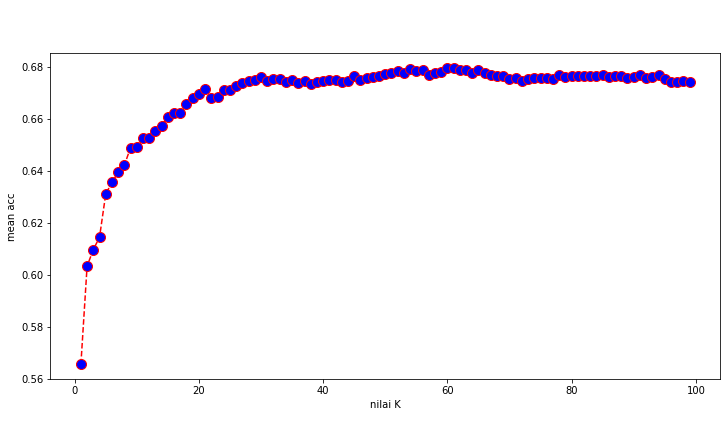

In [13]:
plt.figure(figsize=(12,6))
plt.plot(range(1,100),acc, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('\n\n')
plt.xlabel('nilai K\n')
plt.ylabel('mean acc')
plt.savefig('errKnn1-100.png')

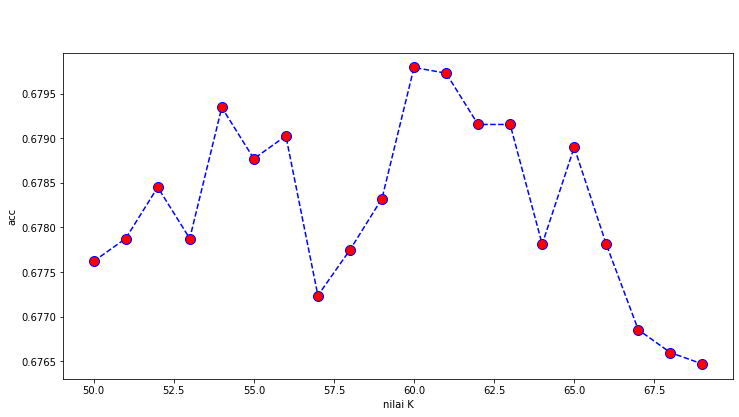

In [14]:
plt.figure(figsize=(12,6))
plt.plot(range(50,70),acc[49:69], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('\n\n')
plt.xlabel('nilai K')
plt.ylabel('acc')
plt.savefig('accKnn40-100.png')
# akurasi tertinggi 76 dan 54

In [15]:
# files.download('errKnn1-100.png')
# files.download('accKnn40-100.png')

# Nearest Neighbor

In [16]:
model = KNeighborsClassifier(n_neighbors = 60)
scoring = {'accuracy': make_scorer(metrics.accuracy_score),
           'precision': make_scorer(metrics.precision_score, average = 'weighted'),
           'recall': make_scorer(metrics.recall_score, average = 'weighted'),
           'f1_weighted': make_scorer(metrics.f1_score, average = 'weighted')}
t = time()
hasil= cross_validate(model,text_tw, label_tw, scoring=scoring,
                       cv=10, return_train_score=True)
test_time = time() - t
d = pd.DataFrame(params)
d['test acc']   = hasil['test_accuracy']
d['test pre']   = hasil['test_precision']
d['test rec']   = hasil['test_recall']
d['test f1 ']   = hasil['test_f1_weighted']
d['train acc']  = hasil['train_accuracy']
d['train pre']  = hasil['train_precision']
d['train rec']  = hasil['train_recall']
d['train f1 ']  = hasil['train_f1_weighted']
d['time']       = (hasil['fit_time'] + hasil['score_time'])
print_df(d)
y_pred = cross_val_predict(model, text_tw, label_tw, cv=10, n_jobs=-1)
print("\nAccuracy   : %0.3f" % metrics.accuracy_score(label_tw, y_pred))
print("Weighted Precision  : %0.3f" % metrics.precision_score(label_tw, y_pred, average='weighted'))
print("Weighted Recall     : %0.3f" % metrics.recall_score(label_tw, y_pred, average='weighted'))
print("Weighted F1 Score   : %0.3f" % metrics.f1_score(label_tw, y_pred, average='weighted'))
print("Weighted time train : %0.3fs" % test_time)
print("Macro Precision  : %0.3f" % metrics.precision_score(label_tw, y_pred, average='macro'))
print("Macro Recall     : %0.3f" % metrics.recall_score(label_tw, y_pred, average='macro'))
print("Macro F1 Score   : %0.3f" % metrics.f1_score(label_tw, y_pred, average='macro'))
print("Macro time train : %0.3fs" % test_time)
print("\nconfusion matrix:")
print(metrics.confusion_matrix(label_tw, y_pred))
print("\nclassification report:")
print(metrics.classification_report(label_tw, y_pred,
                                    target_names=['Positive','Negative', 'Neutral']))

(ppos, pneg, pneu) = metrics.precision_score(label_tw, y_pred, average=None)
(rpos, rneg, rneu) = metrics.recall_score(label_tw, y_pred, average=None)
(fpos, fneg, fneu) = metrics.f1_score(label_tw, y_pred, average=None)
print("\n         precision  recall   f1")
print("positif    %0.3f" % ppos, "   %0.3f" % rpos, "  %0.3f" % fpos)
print("negatif    %0.3f" % pneg, "   %0.3f" % rneg, "  %0.3f" % fneg)
print("neutral    %0.3f" % pneu, "   %0.3f" % rneu, "  %0.3f" % fneu)
print("accuracy                    %0.3f \n"% metrics.accuracy_score(label_tw, y_pred))

+----+-----+------------+------------+------------+------------+-------------+-------------+-------------+-------------+----------+
|    |   0 |   test acc |   test pre |   test rec |   test f1  |   train acc |   train pre |   train rec |   train f1  |     time |
|----+-----+------------+------------+------------+------------+-------------+-------------+-------------+-------------+----------|
|  0 |   1 |   0.632992 |   0.647106 |   0.632992 |   0.595546 |    0.699993 |    0.727469 |    0.699993 |    0.679915 | 0.961307 |
|  1 |   2 |   0.773657 |   0.787681 |   0.773657 |   0.748129 |    0.685497 |    0.707413 |    0.685497 |    0.664401 | 0.873136 |
|  2 |   3 |   0.805627 |   0.821939 |   0.805627 |   0.790829 |    0.681731 |    0.70225  |    0.681731 |    0.659987 | 0.94525  |
|  3 |   4 |   0.693734 |   0.704508 |   0.693734 |   0.676323 |    0.697008 |    0.717252 |    0.697008 |    0.677158 | 1.38287  |
|  4 |   5 |   0.648338 |   0.682052 |   0.648338 |   0.622292 |    0.701769

In [17]:
from sklearn.model_selection import StratifiedKFold
import statistics

fold = StratifiedKFold(n_splits=10)

X = text_tw
y = label_tw

a = 1
accs = []
weigted = []
for train, test in fold.split(text_tw, label_tw):
  ypred = model.fit(X[train], y[train]).predict(X[test])
  print("Fold ", a)
  (ppos, pneg, pneu) = metrics.precision_score(y[test], ypred, average=None)
  (rpos, rneg, rneu) = metrics.recall_score(y[test], ypred, average=None)
  (fpos, fneg, fneu) = metrics.f1_score(y[test], ypred, average=None)
  weigted.append([metrics.accuracy_score(y[test], ypred), metrics.precision_score(y[test], ypred, average='weighted'),metrics.recall_score(y[test], ypred, average='weighted'),metrics.f1_score(y[test], ypred, average='weighted')])
  print("         precision  recall   f1")
  print("positif    %0.3f" % ppos, "   %0.3f" % rpos, "  %0.3f" % fpos)
  print("negatif    %0.3f" % pneg, "   %0.3f" % rneg, "  %0.3f" % fneg)
  print("neutral    %0.3f" % pneu, "   %0.3f" % rneu, "  %0.3f" % fneu)
  print("accuracy                    %0.3f \n"% metrics.accuracy_score(y[test], ypred))
  print(metrics.confusion_matrix(y[test], ypred))
  print("\n")
  a = a + 1
a = 1
print("         acc   prec   rec    f1")
wpres = []
wrecs = []
wf1ss = []
for acc, wpre, wrec, wf1s in weigted:
  accs.append(acc)
  wpres.append(wpre)
  wrecs.append(wrec)
  wf1ss.append(wf1s)
  print("Fold %2.0f" % a, "%2.3f" % acc, "%2.3f" % wpre, " %2.3f" % wrec, " %2.3f" % wf1s)
  a=a+1

print("\nstdev acc : %0.3f"% statistics.stdev(accs))
print("stdev pre : %0.3f"% statistics.stdev(wpres))
print("stdev rec : %0.3f"% statistics.stdev(wrecs))
print("stdev f1s : %0.3f"% statistics.stdev(wf1ss))

Fold  1
         precision  recall   f1
positif    0.614    0.909   0.733
negatif    0.692    0.468   0.559
neutral    0.660    0.203   0.310
accuracy                    0.633 

[[699  52  18]
 [246 229  14]
 [194  50  62]]


Fold  2
         precision  recall   f1
positif    0.732    0.932   0.820
negatif    0.844    0.830   0.837
neutral    0.837    0.284   0.424
accuracy                    0.774 

[[717  39  13]
 [ 79 406   4]
 [183  36  87]]


Fold  3
         precision  recall   f1
positif    0.745    0.948   0.835
negatif    0.923    0.838   0.879
neutral    0.852    0.395   0.540
accuracy                    0.806 

[[729  22  18]
 [ 76 410   3]
 [173  12 121]]


Fold  4
         precision  recall   f1
positif    0.658    0.874   0.751
negatif    0.785    0.642   0.706
neutral    0.692    0.324   0.441
accuracy                    0.694 

[[672  64  33]
 [164 314  11]
 [185  22  99]]


Fold  5
         precision  recall   f1
positif    0.608    0.906   0.728
negatif    0.790    0.

# GA

In [11]:
fitur_terpilih = pd.read_csv("/content/fitur5p10iknn-pso(1).txt",sep=";", encoding='cp1252')
fitur_terpilih
pilih = []
for x in range(len(fitur_terpilih)):
  pilih.append(fitur_terpilih.loc[x,'0'])

In [12]:
sel = []
for x in feature_names:
  if x in pilih:
    sel.append(1)
  else:
    sel.append(0)
sel = np.array(sel)>0.5
sel

array([ True,  True,  True, ...,  True,  True,  True])

In [13]:
model = KNeighborsClassifier(n_neighbors = 60)
scoring = {'accuracy': make_scorer(metrics.accuracy_score),
           'precision': make_scorer(metrics.precision_score, average = 'weighted'),
           'recall': make_scorer(metrics.recall_score, average = 'weighted'),
           'f1_weighted': make_scorer(metrics.f1_score, average = 'weighted')}
t = time()
hasil= cross_validate(model,text_tw[:,sel], label_tw, scoring=scoring,
                       cv=10, return_train_score=True)
test_time = time() - t
d = pd.DataFrame(params)
d['test acc']   = hasil['test_accuracy']
d['test pre']   = hasil['test_precision']
d['test rec']   = hasil['test_recall']
d['test f1 ']   = hasil['test_f1_weighted']
d['train acc']  = hasil['train_accuracy']
d['train pre']  = hasil['train_precision']
d['train rec']  = hasil['train_recall']
d['train f1 ']  = hasil['train_f1_weighted']
d['time']       = (hasil['fit_time'] + hasil['score_time'])
print_df(d)
y_pred = cross_val_predict(model, text_tw[:,sel], label_tw, cv=10, n_jobs=-1)
print("\nAccuracy   : %0.3f" % metrics.accuracy_score(label_tw, y_pred))
print("Weighted Precision  : %0.3f" % metrics.precision_score(label_tw, y_pred, average='weighted'))
print("Weighted Recall     : %0.3f" % metrics.recall_score(label_tw, y_pred, average='weighted'))
print("Weighted F1 Score   : %0.3f" % metrics.f1_score(label_tw, y_pred, average='weighted'))
print("Weighted time train : %0.3fs" % test_time)
print("Macro Precision  : %0.3f" % metrics.precision_score(label_tw, y_pred, average='macro'))
print("Macro Recall     : %0.3f" % metrics.recall_score(label_tw, y_pred, average='macro'))
print("Macro F1 Score   : %0.3f" % metrics.f1_score(label_tw, y_pred, average='macro'))
print("Macro time train : %0.3fs" % test_time)
print("\nconfusion matrix:")
print(metrics.confusion_matrix(label_tw, y_pred))
print("\nclassification report:")
print(metrics.classification_report(label_tw, y_pred,
                                    target_names=['Positive','Negative', 'Neutral']))

(ppos, pneg, pneu) = metrics.precision_score(label_tw, y_pred, average=None)
(rpos, rneg, rneu) = metrics.recall_score(label_tw, y_pred, average=None)
(fpos, fneg, fneu) = metrics.f1_score(label_tw, y_pred, average=None)
print("\n         precision  recall   f1")
print("positif    %0.3f" % ppos, "   %0.3f" % rpos, "  %0.3f" % fpos)
print("negatif    %0.3f" % pneg, "   %0.3f" % rneg, "  %0.3f" % fneg)
print("neutral    %0.3f" % pneu, "   %0.3f" % rneu, "  %0.3f" % fneu)
print("accuracy                    %0.3f \n"% metrics.accuracy_score(label_tw, y_pred))

+----+-----+------------+------------+------------+------------+-------------+-------------+-------------+-------------+----------+
|    |   0 |   test acc |   test pre |   test rec |   test f1  |   train acc |   train pre |   train rec |   train f1  |     time |
|----+-----+------------+------------+------------+------------+-------------+-------------+-------------+-------------+----------|
|  0 |   1 |   0.631714 |   0.64724  |   0.631714 |   0.593347 |    0.698359 |    0.727394 |    0.698359 |    0.67727  | 1.67516  |
|  1 |   2 |   0.773018 |   0.787792 |   0.773018 |   0.747264 |    0.684147 |    0.708094 |    0.684147 |    0.661952 | 1.59577  |
|  2 |   3 |   0.799872 |   0.817101 |   0.799872 |   0.783219 |    0.679955 |    0.701971 |    0.679955 |    0.657268 | 0.95123  |
|  3 |   4 |   0.693095 |   0.705974 |   0.693095 |   0.675195 |    0.696085 |    0.717709 |    0.696085 |    0.675299 | 0.85924  |
|  4 |   5 |   0.647698 |   0.685071 |   0.647698 |   0.619536 |    0.700988

In [14]:
from sklearn.model_selection import StratifiedKFold
import statistics

fold = StratifiedKFold(n_splits=10)

X = text_tw[:,sel]
y = label_tw

a = 1
accs = []
weigted = []
for train, test in fold.split(text_tw[:,sel], label_tw):
  ypred = model.fit(X[train], y[train]).predict(X[test])
  print("Fold ", a)
  (ppos, pneg, pneu) = metrics.precision_score(y[test], ypred, average=None)
  (rpos, rneg, rneu) = metrics.recall_score(y[test], ypred, average=None)
  (fpos, fneg, fneu) = metrics.f1_score(y[test], ypred, average=None)
  weigted.append([metrics.accuracy_score(y[test], ypred), metrics.precision_score(y[test], ypred, average='weighted'),metrics.recall_score(y[test], ypred, average='weighted'),metrics.f1_score(y[test], ypred, average='weighted')])
  print("         precision  recall   f1")
  print("positif    %0.3f" % ppos, "   %0.3f" % rpos, "  %0.3f" % fpos)
  print("negatif    %0.3f" % pneg, "   %0.3f" % rneg, "  %0.3f" % fneg)
  print("neutral    %0.3f" % pneu, "   %0.3f" % rneu, "  %0.3f" % fneu)
  print("accuracy                    %0.3f \n"% metrics.accuracy_score(y[test], ypred))
  print(metrics.confusion_matrix(y[test], ypred))
  print("\n")
  a = a + 1
a = 1
print("         acc   prec   rec    f1")
wpres = []
wrecs = []
wf1ss = []
for acc, wpre, wrec, wf1s in weigted:
  accs.append(acc)
  wpres.append(wpre)
  wrecs.append(wrec)
  wf1ss.append(wf1s)
  print("Fold %2.0f" % a, "%2.3f" % acc, "%2.3f" % wpre, " %2.3f" % wrec, " %2.3f" % wf1s)
  a=a+1

print("\nstdev acc : %0.3f"% statistics.stdev(accs))
print("stdev pre : %0.3f"% statistics.stdev(wpres))
print("stdev rec : %0.3f"% statistics.stdev(wrecs))
print("stdev f1s : %0.3f"% statistics.stdev(wf1ss))

Fold  1
         precision  recall   f1
positif    0.612    0.912   0.732
negatif    0.693    0.462   0.555
neutral    0.663    0.199   0.307
accuracy                    0.632 

[[701  51  17]
 [249 226  14]
 [196  49  61]]


Fold  2
         precision  recall   f1
positif    0.729    0.934   0.819
negatif    0.851    0.828   0.839
neutral    0.835    0.281   0.421
accuracy                    0.773 

[[718  38  13]
 [ 80 405   4]
 [187  33  86]]


Fold  3
         precision  recall   f1
positif    0.738    0.948   0.830
negatif    0.925    0.836   0.879
neutral    0.843    0.369   0.514
accuracy                    0.800 

[[729  22  18]
 [ 77 409   3]
 [182  11 113]]


Fold  4
         precision  recall   f1
positif    0.655    0.878   0.750
negatif    0.789    0.636   0.704
neutral    0.700    0.320   0.439
accuracy                    0.693 

[[675  62  32]
 [168 311  10]
 [187  21  98]]


Fold  5
         precision  recall   f1
positif    0.606    0.914   0.729
negatif    0.788    0.